In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("probability_sampling.ipynb")

# What is in this file/notebook

Slides: https://docs.google.com/presentation/d/1vZC32UCamhyJWJBQIuP5AXKK896mBges_eO2H3Vo3q4/edit?usp=sharing

How do you use numpy's stats package to generalize a single random variable for:
a) Booleans (T/F)
b) Non-gaussian distributions
c) Discrete variables (a, b, c)
d) Binned "continuous" variables - 0.1-0.2, 0.2-0.3, etc

Think of these as functions as simulating real-world events - query the sensor for if the door is open (y/n), ask where the robot is (contiuous location OR a grid square in the world), ask which room you're in (discrete variable, kitchen dining room, etc). These are all fancy versions of a coin toss (returns T/F with 50% probability each), a roll of the dice (returns 1..6 with equal probability).

ALL of these "simulate probability" routines can be implemented using JUST numpy's uniform number generator  (generates a number between 0 and 1 with all values equally likely). The simplest way to think of all of these methods is that you chop up the unit interval 0..1 into the number of possible outcomes, with each bit of the unit interval representing how likely that event is. Then you just generate a number from 0 to 1 and see which bin you fell into.

For continuous probability functions, you use uniform twice - once to pick the x value, once to pick the y value. We will not do this here.

Why the functions are set up they way they are: You need to input how likely each discrete event is. There's three basic methods for specifying this.
1) List each discrete event and how likely it is
2) All events are equally likely, just say how many there are (bins) and the mapping between the bins and the 'labels'.Usually the bins represent some spatial variable like location or angle, but could be movement
3) There is a function that represents how likely each event is, with the x coordinate representing some continuous variable like distance (think Gaussian error for movement)

For each method that you'll implement the above information is passed in using a dictionary. I'm using a dictionary (instead of a class) because it's a bit easier to understand/implement, but the 'right' way to do this is as a class (see the last, optional, problem).

In [2]:
# Install a pip package in the current Jupyter kernel
# Note: this is a safety check in case your JN install was not in the same place as your libraries
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib

In [3]:
# The imports you'll need
from numpy import random
import numpy as np
import matplotlib.pyplot as plt

## Boolean
Simplest case - returns True or False, with some probability

Since probability of returning False is 1-prob(True), only need to specify one value in info_variable info_variable["prob_return_true"] has the probability of returning True

In [4]:
def sample_boolean_variable(info_variable):
    """ Generate one sample from a boolean variable
    @param info_variable contains the probability of the sensor returning True
    @returns True or False """

    # Probabilities have to be between 0 and 1...
    if info_variable["prob_return_true"] < 0.0 or info_variable["prob_return_true"] > 1.0:
        ValueError(f"Value {info_variable['prob_return_true']} not between zero and one")

    # First, use random.uniform to generate a number between 0 and one. Note that this is a uniform distribution, not
    #  a Gaussian one
    zero_to_one = random.uniform()

    # See slides - if the random variable is below the probability of returning true, return true. Otherwise, return false
    return zero_to_one < info_variable["prob_return_true"]
    ...

In [5]:
# First, check that you have no obvious syntax errors 
boolean_variable = {"prob_return_true": 0.7}
ret_val = sample_boolean_variable(boolean_variable)
if ret_val is True or ret_val is False:
    print("sample_boolean: Passed syntax check")


sample_boolean: Passed syntax check


In [6]:
# Test function
def test_boolean(test_prob_value=0.6, b_print=True):
    """ Check if the sample_boolean is doing the right thing by calling it lots of times
    @param test_prob_value - any value between 0.0 and 1.0
    @param b_print - whether or not to print out intermediate results
    @returns True if sample_boolean_variable is working correctly"""

    if b_print:
        print("Testing boolean")
    boolean_variable = {"prob_return_true": test_prob_value}

    count_true = 0
    count_false = 0
    for _ in range(0, 10000):
        if sample_boolean_variable(boolean_variable) == True:
            count_true += 1
        else:
            count_false += 1

    perc_true = count_true / (count_true + count_false)
    if b_print:
        print(f"Perc true from sampling: {perc_true}, expected {boolean_variable['prob_return_true']}")
    if not np.isclose(perc_true, boolean_variable["prob_return_true"], atol=0.05):
        if b_print:
            print("Failed")
        return False

    if b_print:
        print("Passed")
    return True

In [7]:
# Note: This should return true and print out passed. However, sometimes the random number generator will not be
#  your friend and it will fail - you're expecting the count to come out around 0.6 +- noise
print(f"Boolean result: {test_boolean()}")

Testing boolean
Perc true from sampling: 0.5938, expected 0.6
Passed
Boolean result: True


In [8]:
grader.check("boolean_sample")

boolean_sample results: All test cases passed!

# Discrete

A list of discrete variables and their corresponding likelihood.

Because we need one value for each variable, and a name for each variable, store this as name/probabilty pair. Name is the key, probability is the value

If you have forgotten how to do dictionaries, go do the tutorial on dictionaries before attempting this problem

Hint: You want the .items() iterator. If you don't know what that is, or don't know what a key, value pair is, go do the tutorial.

In [9]:
def sample_discrete_variable(info_variable):
    """ Generate one sample from the given discrete variable distribution
    Your code should NOT need to know what the actual keys are, how many there are, or what
    the actual values are - i.e., your code should NOT include things like
             if key == "True" or if z < 0.8
    @param info_variable contains pairs of values with probabilities. Probabilites should sum to one
    @returns one of the discrete values (keys) in the dictionary """

    # First, I'll do some checks for you
    for v in info_variable.values():
        # Probabilities have to be between 0 and 1...
        if v < 0.0 or v > 1.0:
            ValueError(f"Value {v} not between zero and one")

    # And they have to sum to one
    if not np.isclose(sum(info_variable.values()), 1.0):
        ValueError(f"Sum of probabilities should be 1, is {sum(info_variable.values())}")

    # Now, use random to generate a number between 0 and one
    zero_to_one = random.uniform()

    #Iterate over the list of keys/value pairs, summing all the values
    test_sum = 0
    for key, value in  info_variable.items():
        test_sum += value
        #If the RNG value is less than the current sum, then it is within the 'range' assigned to that item
        #(Passing through the loop implicitly checks that it is greater than the sum of all items before it)
        if zero_to_one < test_sum:
            #return the key and exit the for loop
            return key


In [10]:
# Syntax check - does your code run and return a key?

check_discrete_tri = {"red": 0.2, "green": 0.5, "blue": 0.3}
ret_value = sample_discrete_variable(check_discrete_tri)
if ret_value == "red" or ret_value == "green" or ret_value == "blue":
    print("Discrete: Passed syntax check")

Discrete: Passed syntax check


In [11]:
def test_discrete(b_print=True):
    if b_print:
        print("Testing discrete, three cases")
    # The following for loop will loop through each of these in turn. It is NOT doing them all at the
    #  same time - the first time through the for loop it will check the boolean case, the second time
    #  the red, green, blue, the third time the quad one
    check_boolean = {"True": 0.6, "False": 0.4}
    check_discrete_tri = {"red": 0.2, "green": 0.5, "blue": 0.3}
    check_discrete_quad = {"kitchen": 0.2, "living room": 0.3, "dining room": 0.3, "bed room": 0.2}
    for check_variable in [check_boolean, check_discrete_tri, check_discrete_quad]:
        # For each discrete variable, set the counts to be zero; save as dictionary (rather than array/list) because
        #   the keys are strings
        counts = {}
        for k in check_variable.keys():
            counts[k] = 0

        # 'throw the dice' multiple times, and update counts as you go
        n_samples = 50000
        for _ in range(0, n_samples):
            # Which discrete variable?
            discrete_value = sample_discrete_variable(check_variable)
            # Add one to that discrete variable's count
            counts[discrete_value] += 1

        # Now compare the percentage values
        for k, v in check_variable.items():
            perc = counts[k] / n_samples
            if b_print:
                print(f"Discrete value: {k}, got: {perc}, expected {v}")

            if not np.isclose(perc, v, atol=0.05):
                if b_print:
                    print("Failed")
                return False
    if b_print:
        print("Passed")
    return True

In [12]:
# Note, this is a little slow
print(f"Discrete result: {test_discrete()}")

Testing discrete, three cases


Discrete value: True, got: 0.6016, expected 0.6
Discrete value: False, got: 0.3984, expected 0.4
Discrete value: red, got: 0.19934, expected 0.2
Discrete value: green, got: 0.4996, expected 0.5
Discrete value: blue, got: 0.30106, expected 0.3
Discrete value: kitchen, got: 0.1991, expected 0.2
Discrete value: living room, got: 0.30238, expected 0.3
Discrete value: dining room, got: 0.29966, expected 0.3
Discrete value: bed room, got: 0.19886, expected 0.2
Passed
Discrete result: True


In [13]:
grader.check("discrete")

discrete results: All test cases passed!

# Bins 

This is actually a special case of the previous function - just that we don't explicitly label the bins; instead the labels are set to the value at the center of the bin. Rather than specifying unique labels for each bin,
just provide the start/stop boundaries and the number of divisions. Assumes all bins are equally likely.

Your solution should NOT have a loop in it - you should be able to calculate which bin zero_to_one lies in directly (see np.floor(x)).

In [14]:
def sample_bin_variable(info_variable):
    """Return the center location of the bin the sensor value lies in
    @param info_variable - bin start and stop, number of bins
    @return The value (center) associated with the bin"""

    zero_to_one = random.uniform()
    # TODO:
    #  Step 1: Calculate the size of each bin ON THE UNIT INTERVAL
    unit_bin_size = 1/info_variable["n bins"]
    #  Step 2: Use np.floor to find the INDEX of the bin
    bin_index = np.floor(zero_to_one/unit_bin_size)
    #  Step 3: Calculate the center of the bin with that index on the (start, stop) interval
    bin_size = abs((info_variable["stop"] - info_variable["start"])/info_variable["n bins"])
    #Important to remember to adjust for the nonzero start value
    return (bin_index+0.5)*bin_size + info_variable["start"]

In [15]:
# Checking the syntax of the call
check_bins = {"start": -2.0, "stop": 3.0, "n bins": 10}
bin_loc = sample_bin_variable(check_bins)
if check_bins["start"] < bin_loc < check_bins["stop"]:
    print("bin sampling: return value is in correct range")

bin sampling: return value is in correct range


In [16]:
# Check returns center of bin
check_return_center = {"start": 0.0, "stop": 1.0, "n bins": 2}
bin_loc = sample_bin_variable(check_return_center)
if not (np.isclose(bin_loc, 0.25) or np.isclose(bin_loc, 0.75)):
    print(f"If two bins, the first bin goes from 0 to 0.5, the second from 0.5 to 1.0, so return either 0.25 or 0.75 (yours was {bin_loc})")

In [17]:
def test_bins(b_print=True):
    if b_print:    
        print("Testing bins")
    # Provide the start and stop values, and the number of bins
    check_bins = {"start": -2.0, "stop": 3.0, "n bins": 10}

    counts = np.zeros(check_bins["n bins"])

    n_samples = 50000
    bin_width = (check_bins["stop"] - check_bins["start"]) / check_bins["n bins"]
    for _ in range(0, n_samples):
        # Which bin location was selected?
        bin_loc = sample_bin_variable(check_bins)

        # Convert back to the bin id
        bin = int(np.floor((bin_loc - check_bins["start"]) / bin_width))
        # Add one to that
        counts[bin] += 1

    # All of the percentage values should be the same
    perc_expected = 1.0 / check_bins["n bins"]
    for i, count in enumerate(counts):
        perc_found = count / n_samples
        bin_loc = check_bins["start"] + (i + 0.5) * bin_width
        if b_print:
            print(f"Bin loc {bin_loc} perc {perc_found} expected {perc_expected}")

        if not np.isclose(perc_found, perc_expected, atol=0.05):
            if b_print:
                print("Failed")
            return False
    if b_print:
        print("Passed")
    return True

In [18]:
print(f"Bin result: {test_bins()}")

Testing bins
Bin loc -1.75 perc 0.09862 expected 0.1
Bin loc -1.25 perc 0.1016 expected 0.1
Bin loc -0.75 perc 0.10016 expected 0.1
Bin loc -0.25 perc 0.09766 expected 0.1
Bin loc 0.25 perc 0.10136 expected 0.1
Bin loc 0.75 perc 0.10168 expected 0.1
Bin loc 1.25 perc 0.10008 expected 0.1
Bin loc 1.75 perc 0.09986 expected 0.1
Bin loc 2.25 perc 0.10036 expected 0.1
Bin loc 2.75 perc 0.09862 expected 0.1
Passed
Bin result: True


In [19]:
grader.check("bins")

bins results: All test cases passed!

## Gaussian sampling
This is a generic Gaussian noise variable - I'm including it here because you'll need it in subsequent assignments. But it's basically "store mu and sigma, then use those to generate noise"

In [20]:
def sample_gaussian_variable(info_variable):
    """Return a sample from the Gaussian
    @param info_variable - mu and sigma
    @return A sample from the Gaussian"""

    return random.normal(info_variable["mu"],info_variable["sigma"])

In [21]:
# Checking syntax of call
check_gaussian = {"mu": 1.2, "sigma": 0.2}
sample = sample_gaussian_variable(check_gaussian)
print(f"Sample value should be a number: {sample}")

Sample value should be a number: 1.1164999366937565


In [22]:
def test_gaussian(b_print=True):
    """Test the gaussian distribution by seeing if the mean/sd are the same
    @param b_print print out test results y/n
    """
    if b_print:
        print("Testing Gaussian")
    # Provide mu and sigma
    check_gaussian = {"mu": 1.2, "sigma": 0.2}

    n_samples = 50000
    # This does the for loop "in one line" - read this as
    #   for _ in range()
    #       sample_gaussian...
    samples = [sample_gaussian_variable(check_gaussian) for _ in range(0, n_samples)]

    # Should get out same mu/sigma
    samples_mean = np.mean(samples)
    samples_sigma = np.std(samples)

    if not np.isclose(samples_mean, check_gaussian["mu"], atol=0.05):
        raise ValueError(f"Failed Gaussian, expected {check_gaussian['mu']}, got {samples_mean}")

    if not np.isclose(samples_sigma, check_gaussian['sigma'], atol=0.05):
        raise ValueError(f"Failed Gaussian, expected {check_gaussian['sigma']}, got {samples_sigma}\n")

    if b_print:
        print("Passed\n")
    return True

In [23]:
print(f"Gaussian result: {test_gaussian()}")

Testing Gaussian
Passed

Gaussian result: True


In [24]:
grader.check("Gaussian")

Gaussian results: All test cases passed!

<!-- BEGIN QUESTION -->

# Optional: Probability mass function (discrete) 

This is a more general version of the previous bin variable, with the main difference being that each bin has a different liklihood (as specified by the input function). So it's a combination of the discrete variable (using a running sum to determine which bin you fall in) and the bins (chopping up a continuous variable into bins).

Technical note: In theory land, there is a difference between doing this as a continuous function (probability density) versus chopping it up into pieces (probability mass). You can actually do continuous functions, but it's a bit trickier and we don't need it (see for example https://www.comsol.com/blogs/sampling-random-numbers-from-probability-distribution-functions/)

For this example we're going to use a class instead of a method because (in order to make it efficient) you want to pre-calculate a running sum from the given probabilities. It would be very expensive to do this every time you asked for a sample, like you did in the discrete problem.

This is also a good time to do some fancy numpy array stuff, namely, using "where" to find the index (instead of writing your own for loop)

In [25]:
class SampleProbabilityMassFunction:
    def __init__(self, in_pdf, x_range=(0.0, 1.0), n_bins=100):
        """ Given a probability mass function, what range of x to use, and the number of samples, create the running
        sum/data needed to generate random samples from that pmf
        @param in_pdf - the function representing the probability distribution
        @param x_range - min and max x values as a tuple
        @param n_bins - number of bins """

        # TODONE - Initialize correctly
        #  Where the bins start and end
        #  The amount of probability to put in each bin
        #  The running sum

        #First, precalculate the center of each bin:
        #initialize the array
        self.bin_centers = np.zeros(n_bins)
        #calculate the bin size from the range and number of bins
        self.bin_size = (x_range[1] - x_range[0])/n_bins
        #Enter the location of each pin center
        for i in range(0,len(self.bin_centers)):
            self.bin_centers[i] = x_range[0] + self.bin_size*(i+0.5)
            
        
        # Create the pmf by evaluating in_pdf at the center of each bin
        #   Don't forget to normalize - the sum of self.bin_heights should be 1
        self.bin_heights = in_pdf(self.bin_centers)/sum(in_pdf(self.bin_centers))
        
        # Running sum of probabilities - bin_sum[i] = sum(bin_heights[0:i])
        #  Note: It's a bit easier to generate_sample if you make this array n_bins+1, with the first value being 0
        #   and the last value being 1

        #Initialize the running sum array
        self.bin_sum = np.zeros(n_bins+1)

        #Each entry in the running bin sum is the previous sum + the current probablility
        for i in range(1,len(self.bin_sum)):
            self.bin_sum[i] = self.bin_sum[i-1] + self.bin_heights[i-1]

    def generate_sample(self):
        """ Draw one sample from the pmf
        Very similar to the discrete example above, for picking which bin, except you've pre-calculated the running sum.
        Very similar to bin_sample for returning the bin center, exept you've pre-calculated the bin centers
        @return bin center """
        zero_to_one = random.uniform()

        # You want the i where bin_sum[i] <= zero_to_one < bin_sum[i+1]
        # Fancy version: Use np.where

        #Use np.where to find all the values where bin_sum is greater than the random value
        #get the largest index bin_sum from this list, subtract one to offset for the 0th entry in bin_sum
        #Return the bin center
        return self.bin_centers[np.max(np.where(zero_to_one >= self.bin_sum))]


    def _generate_counts(self, n_samples):
        """ Generate n samples
        @param n_samples - number of samples
        @returns a numpy array with the counts for each bin, normalized"""

        # Counts
        counts = np.zeros(self.bin_centers.shape[0])

        # Make sure to take enough samples for all of the bins...
        bin_width = self.bin_centers[1] - self.bin_centers[0]
        for _ in range(0, self.bin_centers.shape[0] * 100):
            x_value = self.generate_sample()
            bin_index = np.ceil((x_value - self.bin_centers[0]) / bin_width)
            counts[int(bin_index)] += 1.0

        # Normalize
        counts = counts / sum(counts)
        return counts

    def test_self(self, in_pdf):
        """ Check/test function
        @param in_pdf - the pdf function used to generate the values
        @returns True/False"""

        # Expected probability values
        expected_probs = in_pdf(self.bin_centers)
        # Normalize
        expected_probs /= np.sum(expected_probs)

        counts = self._generate_counts(100 * self.bin_centers.shape[0])

        for exp, c in zip(expected_probs, counts):
            print(f"pmf perc {c} expected {exp}")

            if np.abs(exp - c) > 0.1:
                print("Failed")
                return False

        print("Passed")
        return True


In [26]:
def pdf(x):
    """ Made-up pdf (a quadratic). Can be anything, as long as it's not negative
    @param x
    @ return (x+1) * (x+1) + 0.1"""
    return (x+1) ** 2 + 0.1

In [27]:
# Syntax check
x_min = -2.0
x_max = 1.0
n_bins = 10

# Make the class
my_sample = SampleProbabilityMassFunction(pdf, (x_min, x_max), n_bins)
# Generate a sample
ret_value = my_sample.generate_sample()

if x_min < ret_value < x_max:
    print("PMF: Passed syntax check")

PMF: Passed syntax check


In [28]:
def test_pmf(b_do_plot=True):
    # Make the class
    x_min = -2.0
    x_max = 1.0
    n_bins = 10
    print("Sample pmf")
    my_sample = SampleProbabilityMassFunction(pdf, (x_min, x_max), n_bins)

    if not b_do_plot:
        return my_sample.test_self(pdf)
    
    print(f"Passed test: {my_sample.test_self(pdf)}")
    
    # Plot the results
    _, axs = plt.subplots(1, 2)
    xs = np.linspace(x_min, x_max, n_bins * 10)
    ys = pdf(xs)
    ys = ys / sum(pdf(my_sample.bin_centers))
    axs[0].plot(xs, ys, '-k', label="pdf")
    axs[0].plot(my_sample.bin_centers, my_sample.bin_heights, 'bX', label="pmf")
    axs[0].legend()
    axs[0].set_title("pdf to pmf")

    # The more samples you take, the more it will look like the pmf
    counts = my_sample._generate_counts(1000 * n_bins)
    axs[1].plot(xs, ys, '-k', label="pdf")
    axs[1].plot(my_sample.bin_centers, counts, 'bX', label="pmf samples")
    axs[1].legend()
    axs[1].set_title("Sampled pmf")
    
    return True

Sample pmf
pmf perc 0.071 expected 0.07528604118993136
pmf perc 0.047 expected 0.0368421052631579
pmf perc 0.017 expected 0.014874141876430205
pmf perc 0.006 expected 0.009382151029748284
pmf perc 0.024 expected 0.02036613272311212
pmf perc 0.046 expected 0.04782608695652172
pmf perc 0.085 expected 0.09176201372997711
pmf perc 0.141 expected 0.15217391304347827
pmf perc 0.23 expected 0.2290617848970251
pmf perc 0.333 expected 0.32242562929061785
Passed
Passed test: True


True

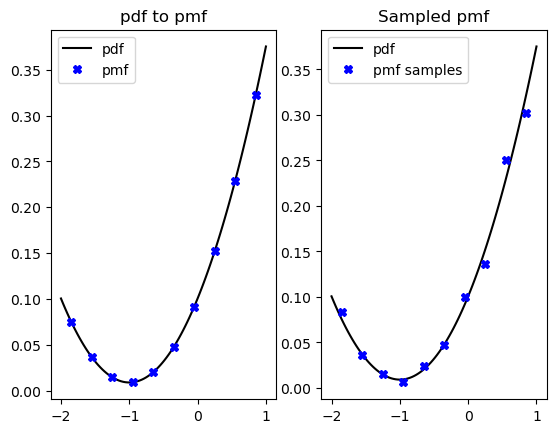

In [29]:
test_pmf()

<!-- END QUESTION -->

## Hours and collaborators
Required for every assignment - fill out before you hand-in.

Listing names and websites helps you to document who you worked with and what internet help you received in the case of any plagiarism issues. You should list names of anyone (in class or not) who has substantially helped you with an assignment - or anyone you have *helped*. You do not need to list TAs.

Listing hours helps us track if the assignments are too long.

In [30]:

# TODO - set to correct value               
# List of names (creates a set)
worked_with_names = {"Osian Leahy"}
# List of URLS TAF24 (creates a set)
websites = {"Stackoverflow", "numpy.org","docs.python.org","GeeksForGeeks","DigitalOcean"}
# Approximate number of hours, including lab/in-class time
hours = 2


In [31]:
grader.check("hours_collaborators")

hours_collaborators results: All test cases passed!

### To submit

- Do a restart then run all to make sure everything runs ok
- Save the file
- Submit this .ipynb file through gradescope, Homework 1
- Take out/suppress all print statements

If the Gradescope autograder fails, please check here first for common reasons for it to fail
    https://docs.google.com/presentation/d/1tYa5oycUiG4YhXUq5vHvPOpWJ4k_xUPp2rUNIL7Q9RI/edit?usp=sharing

